In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import models
import train
import metrics as m

In [2]:
train.set_seed(0)

In [3]:
# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Load data
data_dir = 'data/hymenoptera_data'

train_dataset = datasets.ImageFolder(data_dir + '/train', train_transforms)
validation_dataset = datasets.ImageFolder(data_dir + '/val', validation_transforms)
class_names = train_dataset.classes

batch_size = 5
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True
)


In [5]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(validation_dataset)}')

Number of training examples: 244
Number of validation examples: 153


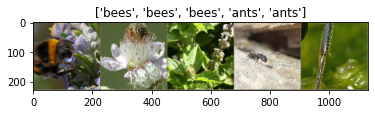

In [6]:
# See some data

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# Device GPU/CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [8]:
# Model
model = models.Resnet_18(out_features=2)

if(device.type == 'cuda'):
    model.to(device)

In [9]:
lr = 0.001
epochs = 10

# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)

model, metrics = train.train(
    model,
    train_loader,
    validation_loader,
    optimizer,
    criterion,
    device,
    epochs,
    batch_size,
    lr, 
    net_class='cnn',
    one_hot=True
    )

Resnet_18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

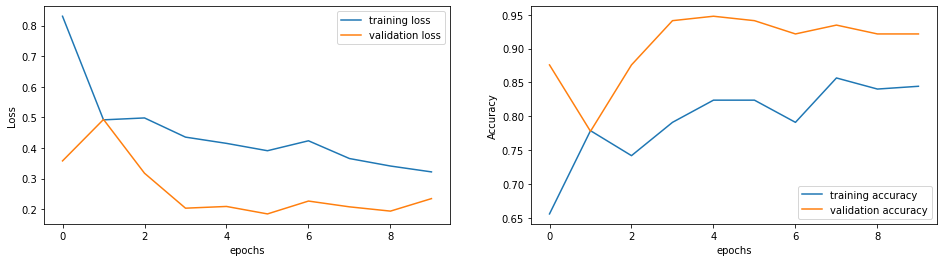

In [10]:
# Print metrics
train.plot_train_metrics(metrics)

Test loss: 0.22440015632779367
Test accuracy: 0.9215686274509803


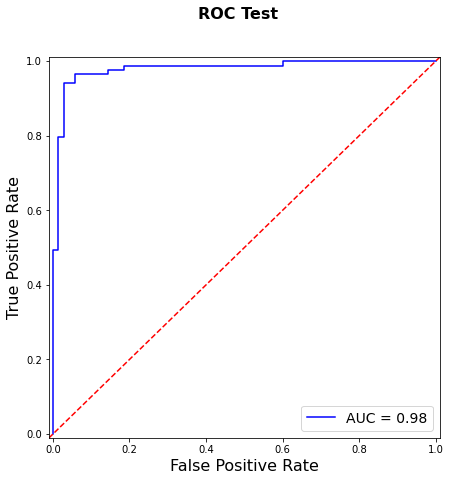

In [11]:
# Test model
test_labels, test_predictions, test_metrics = train.test_model(
    model,
    validation_loader,
    criterion,
    device,
    batch_size,
    net_class='cnn',
    one_hot=True
)

# Plot ROC and AUC
m.plot_roc_curve(test_labels, test_predictions, one_hot=True)
print('Test loss: ' + str(test_metrics[0]))
print('Test accuracy: ' + str(test_metrics[1]))

Metrics for 0.5 threshold


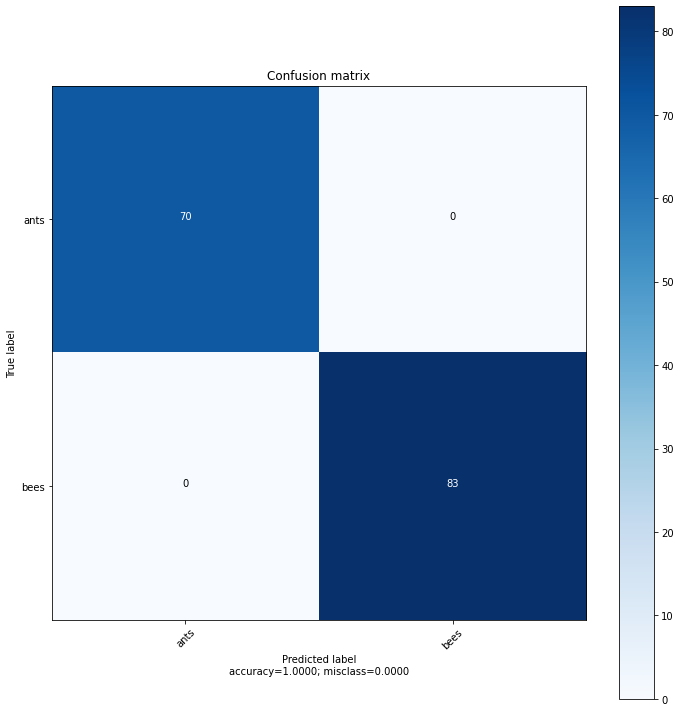

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        83

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153

_____________________________________



In [12]:
target_names = ['ants', 'bees']


result = m.get_metrics(test_labels, test_predictions)
print('Metrics for {0} threshold'.format(0.5))
m.plot_confusion_matrix(
    result[1],
    target_names,
    normalize=False
)
print(result[0])
print('_____________________________________')
print('')